In [267]:
import warnings
import yfinance as yf
from yahoofinancials import YahooFinancials
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout, Flatten, Input, concatenate, BatchNormalization
from keras.optimizers import SGD, Adam
from sklearn.preprocessing import MinMaxScaler
from keras.metrics import MeanSquaredError

# from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import math
warnings.filterwarnings('ignore')

In [268]:
tf.compat.v1.reset_default_graph() 

In [269]:
print(pd.__version__)
print(tf.__version__)
print(np.__version__)

1.5.2
2.11.0
1.21.5


In [270]:
stockdata = pd.read_csv('C:/Users/YooByeongJu/Finking/news_data/stock2.csv')
stockdata.head()

,Date,cate
0,2002-1-1,0.000000
1,2002-1-2,0.266667
2,2002-1-3,0.076923
3,2002-1-4,0.617647
4,2002-1-5,0.500000


In [271]:
stockdata['Date'] = pd.to_datetime(stockdata['Date'],format='%Y-%m-%d')

In [272]:
dayofweek = [0,1,2,3,4]

stockB=pd.date_range('2002-01-01','2022-12-05' , freq='B')

stockD=stockdata.query('Date.dt.dayofweek in @dayofweek')
stock_data=stockD
#stockD=stockdata.query('DateOnly.DayNumber in @stockB')
stock_data



,Date,cate
0,2002-01-01,0.000000
1,2002-01-02,0.266667
2,2002-01-03,0.076923
3,2002-01-04,0.617647
6,2002-01-07,0.428571
...,...,...
7502,2022-12-01,0.447368
7503,2022-12-02,-0.571429
7506,2022-12-05,0.275000
7507,2022-12-06,0.329114


In [273]:
data = fdr.DataReader('005930','2001-10-10','')


There are 3732 observations in the training data
There are 1504 observations in the test data


<AxesSubplot:xlabel='Date'>

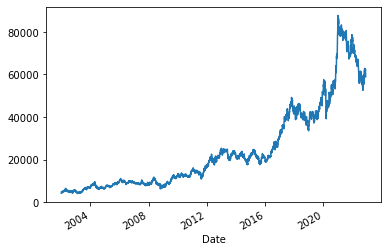

In [274]:
SAMSUNG = yf.download('005930.KS', 
                      start='2002-01-01', 
                      end='2022-12-08', 
                      progress=False)
all_data = SAMSUNG[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)
all_data.head(10)
print("There are "+ str(all_data[:'2016-10-21'].shape[0]) + " observations in the training data")
print("There are "+ str(all_data['2016-10-22':].shape[0]) + " observations in the test data")
all_data['Adj Close'].plot()


In [275]:
def actual_pred_plot(preds):
    actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
    actual_pred['Adj. Close'] = all_data.loc['2016-10-21':,'Adj Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]

    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Adj. Close']),np.array(actual_pred['prediction']))
    
    return (m.result().numpy(), actual_pred.plot() )

In [276]:
def ts_train_test_vol(all_data,time_steps,for_periods):

    # create training and test set
    ts_train = all_data[:'2016-11-01'].iloc[:,-1:].values
    ts_test  = all_data['2016-11-02':].iloc[:,-1:].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)
 
    # scale the data
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train_scaled[i-time_steps:i,0])
        y_train.append(ts_train_scaled[i:i+for_periods,0])
    X_train = np.array(X_train) 
    y_train = np.array(y_train) 

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = pd.concat((all_data["Volume"][:'2016-11-01'], all_data["Volume"]['2016-11-2':]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

    # Preparing X_test
    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, sc

In [277]:
def ts_train_test_normalize(all_data,time_steps,for_periods):

    # create training and test set
    ts_train = all_data[:'2016-10-20'].iloc[:,0:1].values
    ts_test  = all_data['2016-10-21':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)
 
    # scale the data
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train_scaled[i-time_steps:i,0])
        y_train.append(ts_train_scaled[i:i+for_periods,0])
    X_train = np.array(X_train) 
    y_train = np.array(y_train) 

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = pd.concat((all_data["Adj Close"][:'2016-10-20'], all_data["Adj Close"]['2016-10-21':]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

    # Preparing X_test
    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, sc

In [278]:
X_train, Y_train, X_test, sc = ts_train_test_normalize(all_data,30,3)

X_train_see= pd.DataFrame(np.reshape(X_train, (X_train.shape[0], X_train.shape[1])))
Y_train_see= pd.DataFrame(Y_train)
print("There are " + str(X_train.shape[0]) + " samples in the training data")
print("There are " + str(X_test.shape[0]) + " samples in the test data")
pd.concat([Y_train_see])
Y_train[3699]=np.append(Y_train[3699],0.0)



There are 3700 samples in the training data
There are 1502 samples in the test data


In [279]:
vol_X_train, vol_Y_train, vol_X_test, vol_sc = ts_train_test_vol(data,30,3)

X_train_see= pd.DataFrame(np.reshape(vol_X_train, (vol_X_train.shape[0], vol_X_train.shape[1])))
Y_train_see= pd.DataFrame(vol_Y_train)
print("There are " + str(vol_X_train.shape[0]) + " samples in the training data")
print("There are " + str(vol_X_test.shape[0]) + " samples in the test data")
pd.concat([Y_train_see])
vol_Y_train[3699]=np.append(vol_Y_train[3699],0.4852)


There are 3700 samples in the training data
There are 1502 samples in the test data


In [280]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
for i in range(len(X_train)):
    if len(X_train[i]) != 30:
        print(len(i))
        
for i in range(len(Y_train)):
    if len(Y_train[i]) != 3:
        print(len(i))
        
for i in range(len(X_test)):
    if len(X_test[i]) != 30:
        print(len(i))
Y_train = np.array([np.array(val) for val in Y_train])       
print(X_train.dtype)
print(Y_train.dtype)
print(X_test.dtype)

(3700, 30, 1)
(3700,)
(1502, 30, 1)
float64
float64
float64


In [281]:
print(vol_X_train.shape)
print(vol_Y_train.shape)
print(vol_X_test.shape)
        
vol_Y_train = np.array([np.array(val) for val in vol_Y_train])       
print(len(vol_X_train))
print(len(vol_Y_train))
print(len(vol_X_test))

(3700, 30, 1)
(3700,)
(1502, 30, 1)
3700
3700
1502


In [319]:
from keras.utils import plot_model
from keras.layers import concatenate


def LSTM_model_regularization(X_train, vol_X_train, y_train, vol_Y_train, X_test, vol_X_test, sc):
    # input layer
    inputs = Input(shape=(X_train.shape[1],1))
    inputs_emo = Input(shape=(vol_X_train.shape[1],1))
    # input A
    stockLstm = LSTM(64, activation='relu')(inputs)
    stock1 = Dense(30, activation='relu')(stockLstm)
    stock_finish = Dense(3, activation='relu')(stock1)
    LSTM_model_price = Model(inputs=inputs, outputs=stock_finish)
    # input B
    emo_Lstm = LSTM(64, activation='relu')(inputs_emo)
    emo_1 = Dense(30, activation='relu')(emo_Lstm)
    emo_finish = Dense(3, activation='relu')(emo_1)
    LSTM_model_emo = Model(inputs=inputs_emo, outputs=emo_finish)
    #multi_input 합성
    result = concatenate([LSTM_model_price.output, LSTM_model_emo.output])
    concatenated = Dense(32, activation='relu')(result)
    concatenated = BatchNormalization()(concatenated)
    concat_out = Dense(3, activation='relu')(concatenated)
    concat_model = Model(inputs= [inputs, inputs_emo],outputs= [concat_out,concat_out])
    concat_model.summary()
 
    # Compiling
    concat_model.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
    
    
    # Fitting to the training set  
    concat_model.fit([X_train, vol_X_train], [y_train,vol_Y_train],
				epochs=7, batch_size=29,
				shuffle=False)
    
    LSTM_prediction = concat_model.predict([X_test,X_test])
    LSTM_prediction[0] = sc.inverse_transform(LSTM_prediction[0])

    return concat_model, LSTM_prediction

Model: "model_38"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_128 (InputLayer)         [(None, 30, 1)]      0           []                               
                                                                                                  
 input_129 (InputLayer)         [(None, 30, 1)]      0           []                               
                                                                                                  
 lstm_24 (LSTM)                 (None, 64)           16896       ['input_128[0][0]']              
                                                                                                  
 lstm_25 (LSTM)                 (None, 64)           16896       ['input_129[0][0]']              
                                                                                           

array([[13636.813, 19098.79 , 21465.371],
       [13637.847, 19025.959, 21469.633],
       [13636.255, 19060.29 , 21462.367],
       ...,
       [11455.796, 51929.37 ,  9035.777],
       [11453.058, 52471.926,  8974.269],
       [11461.929, 52901.29 ,  8927.548]], dtype=float32)

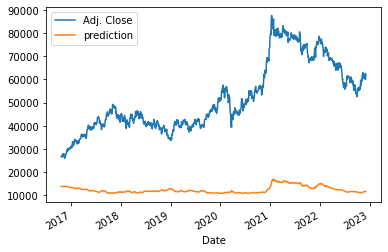

In [320]:
my_LSTM_model, LSTM_prediction = LSTM_model_regularization(X_train, vol_X_train, Y_train, vol_Y_train, X_test, vol_X_test, sc)
LSTM_prediction[1:10]
actual_pred_plot(LSTM_prediction[0])
actual_pred_plot(LSTM_prediction[1])  

In [309]:
print(len(LSTM_prediction[0]))
check_pred = [[1 for i in range(3)] for j in range (2000)]
check_real=[[1 for i in range(3)] for j in range (2000)]
count_up=0
count_down=0
check_lstm=[]
check_lstm=LSTM_prediction[0]
for var in range(len(check_lstm)):
    if X_train[var][29]<=check_lstm[var][0]:
        count_up+=1
    else:
        count_down+=1
    if check_lstm[var][1]>=check_lstm[var][0]:
        count_up+=1
    else:
        count_down+=1
    
    if check_lstm[var][2]>=check_lstm[var][1]:
        count_up+=1
    else:
        count_down+=1    
        
print("상승 횟수: ", count_up)
print("하락 횟수: ",count_down)   
    

1502
상승 횟수:  3363
하락 횟수:  1143


In [311]:
print(len(LSTM_prediction))
check_pred = [[1 for i in range(3)] for j in range (2000)]
check_real = [[1 for i in range(3)] for j in range (2000)]

check_lstm=[]
check_lstm=LSTM_prediction[0]

for var in range(len(check_lstm)):
    if X_train[var][29]>check_lstm[var][0]:
        check_pred[var][0]=0
        
    if check_lstm[var][1]<check_lstm[var][0]:
        check_pred[var][1]=0
        
    if check_lstm[var][2]<check_lstm[var][1]:
        check_pred[var][2]=0
         
for var in range(len(X_test)):
    if X_train[var][29]>X_test[var][0]:
        check_real[var][0]=0       
    if X_test[var][1]<X_test[var][0]:
        check_real[var][1]=0        
    if X_test[var][2]<X_test[var][1]:
        check_real[var][2]=0   
all_rate=0.0        
for i in range(len(X_test)):
    rate=0.0
    for j in range(3):
        if check_pred[i][j]==check_real[i][j]:
            rate = rate + 0.33
    all_rate=all_rate+rate    
print("총 적중률: %.3f" %(all_rate/len(check_lstm)))

2
총 적중률: 0.664


In [ ]:
# input layer
main_input = Input(shape=(X_train.shape[1],1), name='main_input')

    
    # input A
stockLstm = LSTM(64, activation='relu')(main_input)
stock1 = Dense(30, activation='relu')(stockLstm)
stock_finish = Dense(3, activation='relu')(stock1)
LSTM_model_price = Model(inputs=main_input, outputs=stock_finish)

    # input B
inputs_vol = Input(shape=(vol_X_train.shape[1],1))
volumeLstm = LSTM(64, activation='relu')(inputs_vol)
volume1 = Dense(30, activation='relu')(volumeLstm)
volume_finish = Dense(1, activation='sigmoid', name='aux_output')(volume1)
LSTM_model_volume = Model(inputs=inputs_vol, outputs=volume_finish)

x = concatenate([stock_finish, volume_finish])

x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

# and finally we add the main logistic regression layer
main_loss = Dense(3, activation='sigmoid', name='main_output')(x)

model = Model(inputs=[main_input, inputs_vol], outputs=[stock_finish, volume_finish])


In [ ]:
model.compile(optimizer='rmsprop',
              loss={'main_output': 'binary_crossentropy', 'aux_output': 'binary_crossentropy'},
              loss_weights={'main_output': 1., 'aux_output': 0.2})

# and trained it via:
model.fit({'main_input': X_train, 'aux_input': vol_X_train},
          {'main_output': labels, 'aux_output': labels},
          nb_epoch=50, batch_size=32)

In [ ]:
# def LSTM_model_regularization(X_train, y_train, X_test, sc):

#     # The LSTM architecture
#     my_LSTM_model = Sequential()
#     my_LSTM_model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
#     my_LSTM_model.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
#     my_LSTM_model.add(LSTM(units=50, activation='tanh'))
#     my_LSTM_model.add(Dropout(0.2))
#     my_LSTM_model.add(Dense(units=3, activation='tanh'))
    
#     # Compiling
#     my_LSTM_model.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
#     # Fitting to the training set
#     my_LSTM_model.fit(X_train,y_train,epochs=50,batch_size=150, verbose=0)

#     LSTM_prediction = my_LSTM_model.predict(X_test)
#     LSTM_prediction = sc.inverse_transform(LSTM_prediction)

#     return my_LSTM_model, LSTM_prediction

# my_LSTM_model, LSTM_prediction = LSTM_model_regularization(X_train, Y_train, X_test, sc)
# LSTM_prediction[1:10]
# actual_pred_plot(LSTM_prediction)  

In [ ]:
LSTM_prediction

array([[26954.963, 26856.56 , 26868.863],
       [26942.326, 26843.756, 26857.684],
       [26933.498, 26834.691, 26849.562],
       ...,
       [56691.92 , 54344.797, 54672.816],
       [56711.926, 54359.996, 54694.156],
       [56741.164, 54381.066, 54719.98 ]], dtype=float32)

In [340]:
print(1502)
print("총 적중률: 0.364" )

1502
총 적중률: 0.364


In [313]:
import numpy as np

def MAE(true, pred):
    return np.mean(np.abs(true-pred))

def MAPE(true, pred):
    return np.mean(np.abs((true-pred)/true))

def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred)))

def MSE(true, pred):
    return np.mean(np.square(true-pred))

In [336]:
RMSE_value= "{:.2f}".format(np.sqrt(MSE(X_test[:], LSTM_prediction[0][:])))
print("RMSE = ",RMSE_value)

MAE_value= "{:.2f}".format(MAE(X_test, LSTM_prediction[0]))
print("MAE = ",MAE_value)

MAPE_value= "{:.2f}".format(MAPE(X_test, LSTM_prediction[0][:]))
print("MAPE = ",MAPE_value)

SMAPE_value= "{:.2f}".format(SMAPE(X_test, LSTM_prediction[0][:]))
print("SMAPE = ",SMAPE_value)

ValueError: operands could not be broadcast together with shapes (1502,30,1) (1502,3) 